## Preamble

In [1]:
import glob
import os

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import cv2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torcheval.metrics.functional import multiclass_accuracy, multiclass_f1_score

from sklearn.preprocessing import LabelBinarizer

In [2]:
! gpustat --no-color

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

gpu3.datascience.usfca.edu  Mon May 13 18:09:15 2024  550.54.15
[0] NVIDIA TITAN RTX | 37°C,   0 % | 18023 / 24576 MB | ibardak(344M) ibardak(16716M) cwbennie(868M)
[1] NVIDIA TITAN RTX | 88°C,  91 % | 15076 / 24576 MB | ibardak(15070M)
[2] NVIDIA TITAN RTX | 32°C,   0 % |   314 / 24576 MB | rnmohan(232M)
[3] NVIDIA TITAN RTX | 35°C,   0 % | 16918 / 24576 MB | cwbennie(16822M)
[4] NVIDIA TITAN RTX | 70°C,  96 % | 17148 / 24576 MB | ihan2(16554M)
[5] NVIDIA TITAN RTX | 86°C,  89 % | 22618 / 24576 MB | dmgonzalez8(22616M)
[6] NVIDIA TITAN RTX | 51°C,   0 % |  1166 / 24576 MB | dmgonzalez8(1164M)


note that j and z are missing since they're not static signs

## Implementations

* It's a GRAPH problem
    * get hand landmarks (mediapipe?)
    * train on (landmarks, label) pairs
        * experiment with GCN / GAT / PointNet
* They're IMAGEs
    * use mediapipe or similar model to develop consistent bounding boxes for hands
    * Use VGG19 as a backbone and train on (image, label) pairs

# Data Loading / Preprocessing

In [3]:
def get_labels_images(filepath):
    data_dict = {}
    for directory in glob.glob(filepath):
        images = []
        for file in glob.glob(directory + "/color_*.png"):
            images.append(file)
        for file in glob.glob(directory + "/*.jpg"):
            images.append(file)
        data_dict.setdefault(directory[-1], images)

    return data_dict

In [4]:
dataset_dir = os.path.abspath("../dataset/*/*")
data_dict = get_labels_images(dataset_dir)

In [5]:
data_dict.keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'])

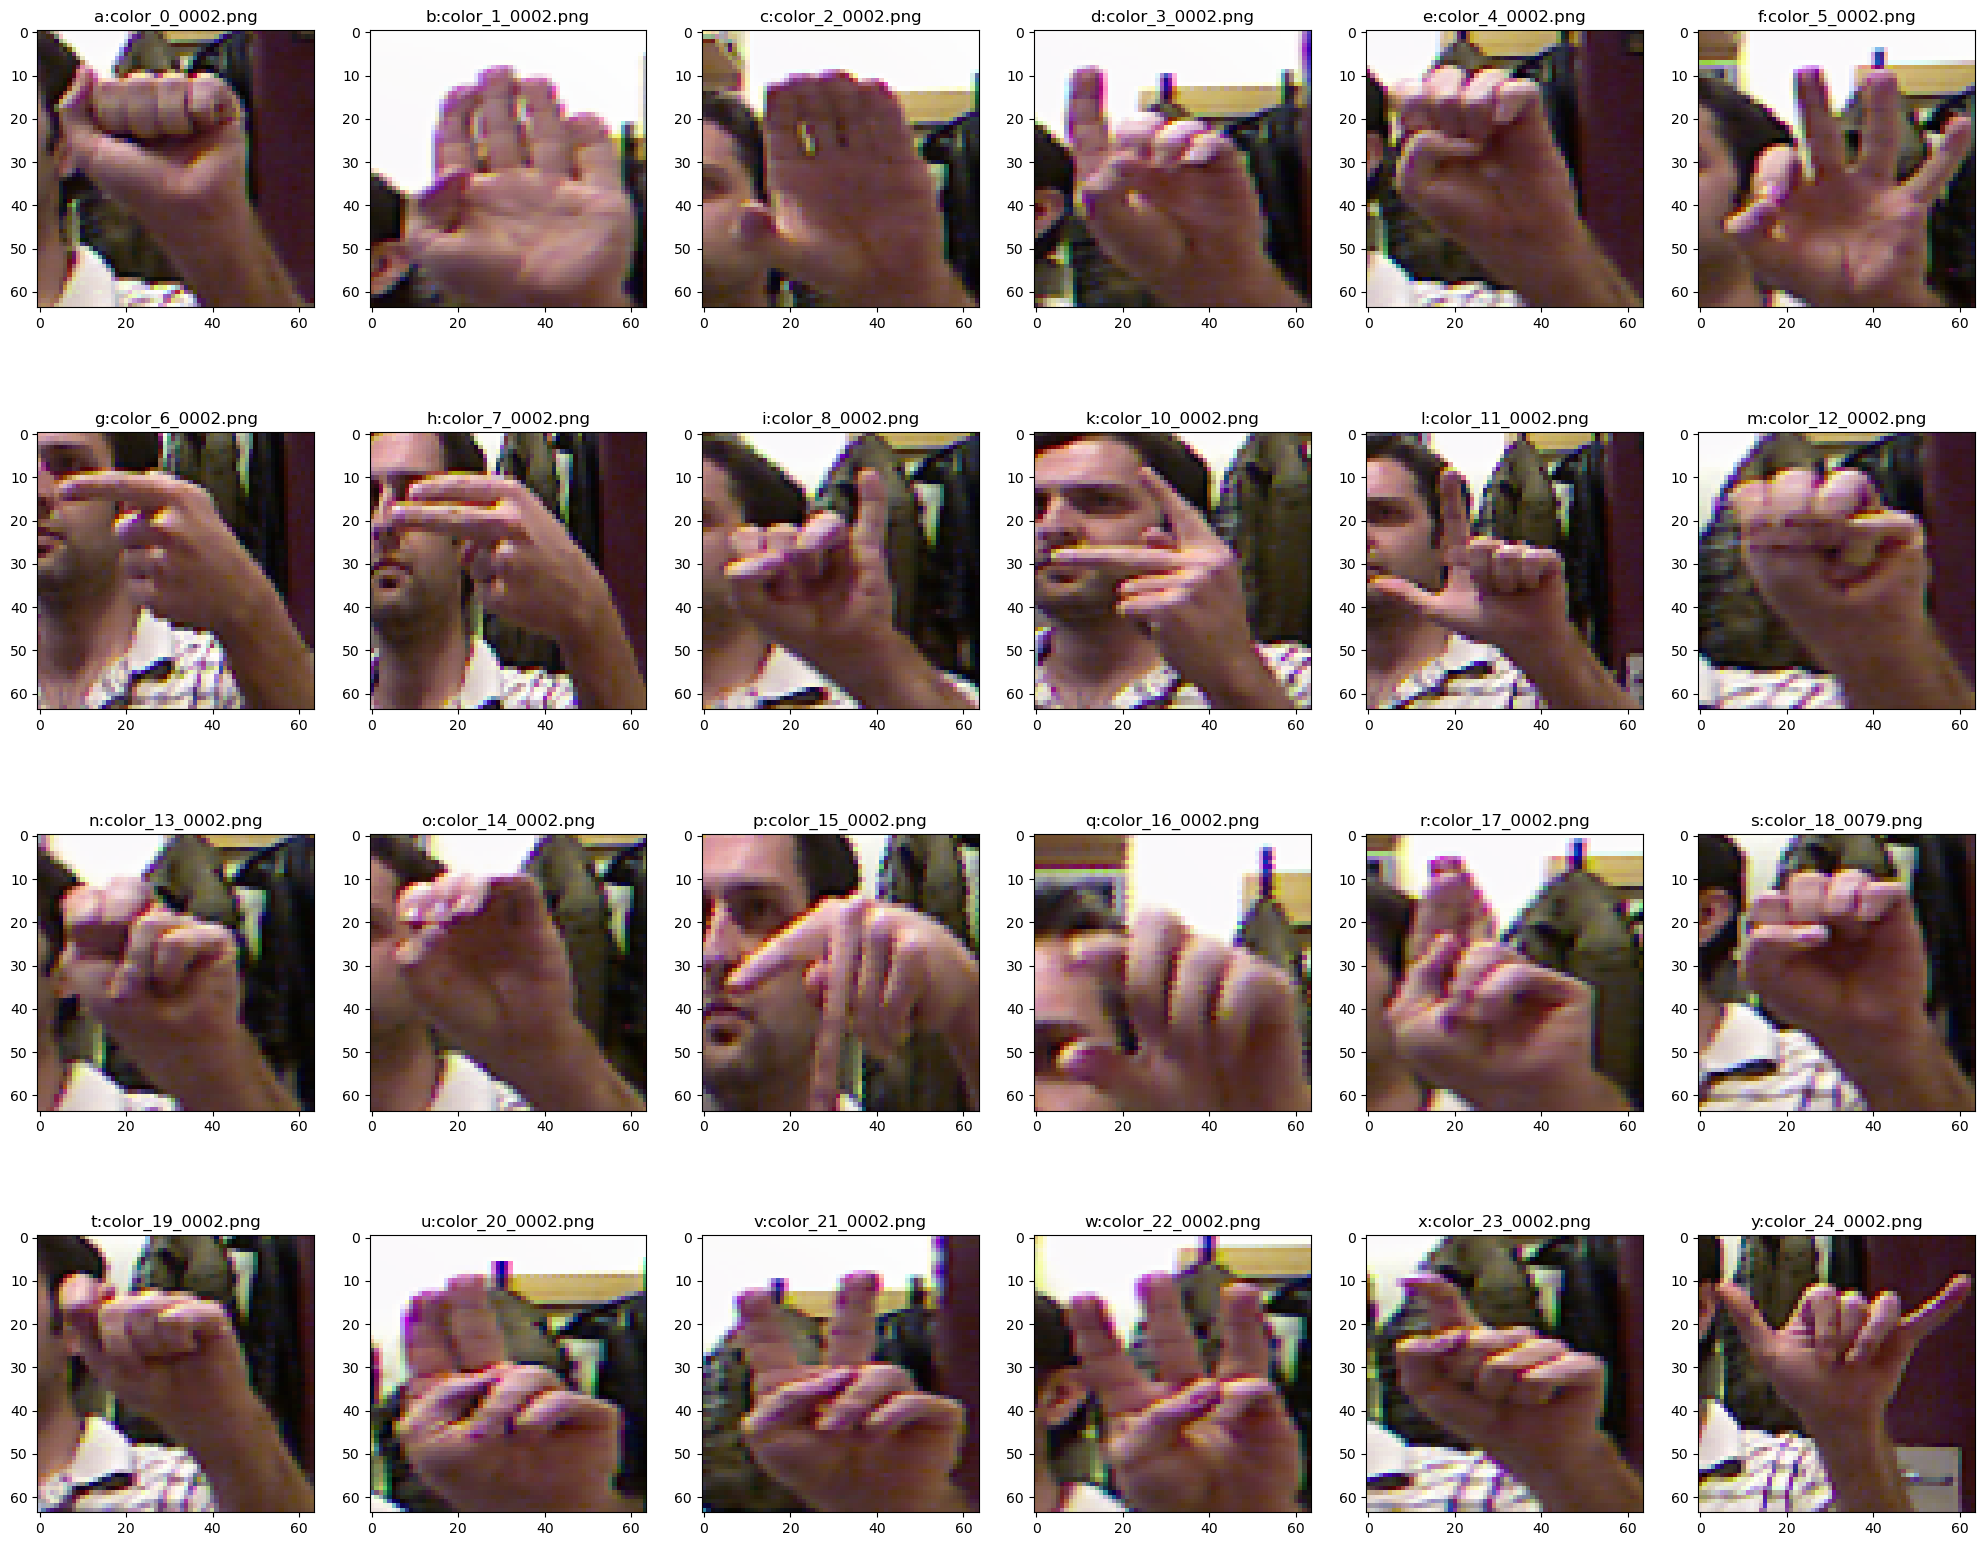

In [6]:
plt.figure(figsize=(25, 20))

for i, (k, v) in enumerate(data_dict.items()):
    img = cv2.imread(v[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    plt.subplot(4, 6, i + 1)
    plt.imshow(img)
    plt.title(k + ":" + os.path.basename(v[0]))

plt.show()

In [7]:
def preprocess_images(dictionary, height=64, width=64):
    images = []
    labels = []
    for k, v in dictionary.items():
        for file in v:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (height, width))
            img = img / 255.0
            images.append(np.moveaxis(img, -1, 0))  # reshape images for torch
            labels.append(k.lower())

    return (np.array(images), np.array(labels).reshape(-1, 1))


images, labels = preprocess_images(data_dict)

In [9]:
images.shape

(12547, 3, 64, 64)

In [10]:
lbl_binarizer = LabelBinarizer()
labels = lbl_binarizer.fit_transform(labels)

In [11]:
train, test = random_split(list(zip(images, labels)), [0.8, 0.2])

train, val = random_split(train, [0.875, 0.125])

In [12]:
# Initialize hyperparameters
N_EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 1e-4

In [13]:
# Create data loaders
train_iterator = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_iterator = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

# Model Definition

In [14]:
model = torchvision.models.vgg.vgg19()

# Replace the original classifier with a new one having the same architecture but with the final layer adjusted for 24 output classes
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 24),  # Final layer with 24 outputs
)

# Freeze the parameters in the feature extraction part of the model
for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

# Verify which parameters are trainable
trainable_parameters = {
    name: param.requires_grad for name, param in model.named_parameters()
}
print(trainable_parameters)

{'features.0.weight': False, 'features.0.bias': False, 'features.2.weight': False, 'features.2.bias': False, 'features.5.weight': False, 'features.5.bias': False, 'features.7.weight': False, 'features.7.bias': False, 'features.10.weight': False, 'features.10.bias': False, 'features.12.weight': False, 'features.12.bias': False, 'features.14.weight': False, 'features.14.bias': False, 'features.16.weight': False, 'features.16.bias': False, 'features.19.weight': False, 'features.19.bias': False, 'features.21.weight': False, 'features.21.bias': False, 'features.23.weight': False, 'features.23.bias': False, 'features.25.weight': False, 'features.25.bias': False, 'features.28.weight': False, 'features.28.bias': False, 'features.30.weight': False, 'features.30.bias': False, 'features.32.weight': False, 'features.32.bias': False, 'features.34.weight': False, 'features.34.bias': False, 'classifier.0.weight': True, 'classifier.0.bias': True, 'classifier.3.weight': True, 'classifier.3.bias': True,

In [15]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [16]:
# Training Loop
# Loop over epochs
for epoch in range(N_EPOCHS):
    # Training Phase
    model.train()  # Set the model to training mode
    epoch_train_loss = 0  # Initialize epoch training loss

    for image, labels in tqdm(train_iterator):
        image, labels = image.float().to(device), labels.float().to(
            device
        )  # Move data to GPU if available

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        predictions = model(image)

        # Compute the loss
        train_loss = criterion(predictions, labels)

        # Backward pass
        train_loss.backward()

        # Update the parameters
        optimizer.step()

        # Accumulate the training loss for this batch
        epoch_train_loss += train_loss.item()

    # Compute average training loss for the epoch
    average_train_loss = epoch_train_loss / len(train_iterator)

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    epoch_val_loss = 0  # Initialize epoch validation loss

    with torch.no_grad():  # No gradient computation during validation
        for image, labels in tqdm(val_iterator):
            image, labels = image.float().to(device), labels.float().to(
                device
            )  # Move data to GPU if available

            # Forward pass
            predictions = model(image)

            # Compute the loss
            val_loss = criterion(predictions, labels)

            # Accumulate the validation loss for this batch
            epoch_val_loss += val_loss.item()

    # Compute average validation loss for the epoch
    average_val_loss = epoch_val_loss / len(val_iterator)

    # Print epoch information
    print(
        f"Epoch: {epoch+1:02} | Train Loss: {average_train_loss:.3f} | Val. Loss: {average_val_loss:.3f}"
    )

100%|██████████| 10/10 [00:00<00:00, 26.44it/s]


Epoch: 01 | Train Loss: 3.126 | Val. Loss: 2.924


100%|██████████| 10/10 [00:00<00:00, 30.36it/s]


Epoch: 02 | Train Loss: 2.687 | Val. Loss: 2.470


100%|██████████| 10/10 [00:00<00:00, 30.64it/s]


Epoch: 03 | Train Loss: 2.337 | Val. Loss: 2.128


100%|██████████| 10/10 [00:00<00:00, 29.41it/s]


Epoch: 04 | Train Loss: 1.987 | Val. Loss: 1.795


100%|██████████| 10/10 [00:00<00:00, 29.47it/s]


Epoch: 05 | Train Loss: 1.708 | Val. Loss: 1.507


100%|██████████| 10/10 [00:00<00:00, 30.40it/s]


Epoch: 06 | Train Loss: 1.459 | Val. Loss: 1.275


100%|██████████| 10/10 [00:00<00:00, 28.65it/s]


Epoch: 07 | Train Loss: 1.265 | Val. Loss: 1.125


100%|██████████| 10/10 [00:00<00:00, 29.56it/s]


Epoch: 08 | Train Loss: 1.140 | Val. Loss: 1.015


100%|██████████| 10/10 [00:00<00:00, 30.04it/s]


Epoch: 09 | Train Loss: 1.021 | Val. Loss: 0.904


100%|██████████| 10/10 [00:00<00:00, 30.70it/s]


Epoch: 10 | Train Loss: 0.937 | Val. Loss: 0.807


100%|██████████| 10/10 [00:00<00:00, 29.40it/s]


Epoch: 11 | Train Loss: 0.847 | Val. Loss: 0.780


100%|██████████| 10/10 [00:00<00:00, 30.46it/s]


Epoch: 12 | Train Loss: 0.808 | Val. Loss: 0.738


100%|██████████| 10/10 [00:00<00:00, 30.18it/s]


Epoch: 13 | Train Loss: 0.749 | Val. Loss: 0.657


100%|██████████| 10/10 [00:00<00:00, 29.18it/s]


Epoch: 14 | Train Loss: 0.705 | Val. Loss: 0.619


100%|██████████| 10/10 [00:00<00:00, 30.18it/s]


Epoch: 15 | Train Loss: 0.665 | Val. Loss: 0.606


100%|██████████| 10/10 [00:00<00:00, 29.92it/s]


Epoch: 16 | Train Loss: 0.632 | Val. Loss: 0.546


100%|██████████| 10/10 [00:00<00:00, 30.85it/s]


Epoch: 17 | Train Loss: 0.598 | Val. Loss: 0.517


100%|██████████| 10/10 [00:00<00:00, 31.16it/s]


Epoch: 18 | Train Loss: 0.556 | Val. Loss: 0.495


100%|██████████| 10/10 [00:00<00:00, 31.33it/s]


Epoch: 19 | Train Loss: 0.532 | Val. Loss: 0.458


100%|██████████| 10/10 [00:00<00:00, 31.20it/s]


Epoch: 20 | Train Loss: 0.500 | Val. Loss: 0.445


100%|██████████| 10/10 [00:00<00:00, 29.57it/s]


Epoch: 21 | Train Loss: 0.482 | Val. Loss: 0.437


100%|██████████| 10/10 [00:00<00:00, 29.39it/s]


Epoch: 22 | Train Loss: 0.463 | Val. Loss: 0.391


100%|██████████| 10/10 [00:00<00:00, 28.53it/s]


Epoch: 23 | Train Loss: 0.434 | Val. Loss: 0.381


100%|██████████| 10/10 [00:00<00:00, 29.28it/s]


Epoch: 24 | Train Loss: 0.420 | Val. Loss: 0.367


100%|██████████| 10/10 [00:00<00:00, 29.63it/s]


Epoch: 25 | Train Loss: 0.394 | Val. Loss: 0.361


100%|██████████| 10/10 [00:00<00:00, 27.07it/s]


Epoch: 26 | Train Loss: 0.377 | Val. Loss: 0.317


100%|██████████| 10/10 [00:00<00:00, 28.90it/s]


Epoch: 27 | Train Loss: 0.360 | Val. Loss: 0.318


100%|██████████| 10/10 [00:00<00:00, 29.68it/s]


Epoch: 28 | Train Loss: 0.347 | Val. Loss: 0.311


100%|██████████| 10/10 [00:00<00:00, 29.80it/s]


Epoch: 29 | Train Loss: 0.329 | Val. Loss: 0.285


100%|██████████| 10/10 [00:00<00:00, 28.45it/s]


Epoch: 30 | Train Loss: 0.327 | Val. Loss: 0.274


100%|██████████| 10/10 [00:00<00:00, 30.88it/s]


Epoch: 31 | Train Loss: 0.302 | Val. Loss: 0.298


100%|██████████| 10/10 [00:00<00:00, 29.40it/s]


Epoch: 32 | Train Loss: 0.302 | Val. Loss: 0.258


100%|██████████| 10/10 [00:00<00:00, 29.59it/s]


Epoch: 33 | Train Loss: 0.287 | Val. Loss: 0.272


100%|██████████| 10/10 [00:00<00:00, 28.51it/s]


Epoch: 34 | Train Loss: 0.279 | Val. Loss: 0.245


100%|██████████| 10/10 [00:00<00:00, 31.54it/s]


Epoch: 35 | Train Loss: 0.245 | Val. Loss: 0.233


100%|██████████| 10/10 [00:00<00:00, 31.28it/s]


Epoch: 36 | Train Loss: 0.252 | Val. Loss: 0.221


100%|██████████| 10/10 [00:00<00:00, 30.28it/s]


Epoch: 37 | Train Loss: 0.236 | Val. Loss: 0.209


100%|██████████| 10/10 [00:00<00:00, 27.12it/s]


Epoch: 38 | Train Loss: 0.237 | Val. Loss: 0.208


100%|██████████| 10/10 [00:00<00:00, 29.41it/s]


Epoch: 39 | Train Loss: 0.230 | Val. Loss: 0.222


100%|██████████| 10/10 [00:00<00:00, 30.83it/s]


Epoch: 40 | Train Loss: 0.213 | Val. Loss: 0.197


100%|██████████| 10/10 [00:00<00:00, 30.34it/s]


Epoch: 41 | Train Loss: 0.200 | Val. Loss: 0.173


100%|██████████| 10/10 [00:00<00:00, 30.25it/s]


Epoch: 42 | Train Loss: 0.193 | Val. Loss: 0.177


100%|██████████| 10/10 [00:00<00:00, 31.28it/s]


Epoch: 43 | Train Loss: 0.194 | Val. Loss: 0.172


100%|██████████| 10/10 [00:00<00:00, 28.40it/s]


Epoch: 44 | Train Loss: 0.186 | Val. Loss: 0.171


100%|██████████| 10/10 [00:00<00:00, 30.43it/s]


Epoch: 45 | Train Loss: 0.185 | Val. Loss: 0.196


100%|██████████| 10/10 [00:00<00:00, 30.40it/s]


Epoch: 46 | Train Loss: 0.170 | Val. Loss: 0.152


100%|██████████| 10/10 [00:00<00:00, 30.46it/s]


Epoch: 47 | Train Loss: 0.160 | Val. Loss: 0.147


100%|██████████| 10/10 [00:00<00:00, 31.13it/s]


Epoch: 48 | Train Loss: 0.152 | Val. Loss: 0.139


100%|██████████| 10/10 [00:00<00:00, 30.27it/s]


Epoch: 49 | Train Loss: 0.156 | Val. Loss: 0.134


100%|██████████| 10/10 [00:00<00:00, 19.73it/s]

Epoch: 50 | Train Loss: 0.149 | Val. Loss: 0.158


In [17]:
with open("vgg_tl.pt", "wb") as file:
    torch.save(model, file)

In [18]:
with open("vgg_tl.pt", "rb") as file:
    model = torch.load(file).to(device)

# Model Evaluation

In [19]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
def get_metrics(model, loader) -> dict:
    model.eval()

    accuracy_scores = []
    f1_scores = []
    test_losses = []

    with torch.no_grad():
        for image, labels in tqdm(loader):
            image, labels = image.float().to(device), labels.float().to(device)
            soft_prediction = model(image)
            label_class = labels.argmax(dim=1)

            accuracy_scores.append(multiclass_accuracy(soft_prediction, label_class))
            f1_scores.append(multiclass_f1_score(soft_prediction, label_class))

            test_loss = criterion(soft_prediction, labels)
            test_losses.append(test_loss)

    loss = torch.tensor(test_losses).mean()
    accuracy = torch.tensor(accuracy_scores).mean()
    f1_score = torch.tensor(f1_scores).mean()

    return {"loss": loss, "accuracy": accuracy, "f1_score": f1_score}

In [21]:
get_metrics(model, train_iterator)

100%|██████████| 69/69 [00:02<00:00, 26.14it/s]


{'loss': tensor(0.1076),
 'accuracy': tensor(0.9710),
 'f1_score': tensor(0.9710)}

In [22]:
get_metrics(model, val_iterator)

100%|██████████| 10/10 [00:00<00:00, 28.09it/s]


{'loss': tensor(0.1581),
 'accuracy': tensor(0.9537),
 'f1_score': tensor(0.9537)}

In [23]:
get_metrics(model, test_loader)

100%|██████████| 20/20 [00:00<00:00, 27.56it/s]


{'loss': tensor(0.1649),
 'accuracy': tensor(0.9473),
 'f1_score': tensor(0.9473)}

In [24]:
data_dict.keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'])

In [25]:
## extra image testing
images = []
labels = []


def load_resize_img(img_path):
    height, width = 64, 64

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (height, width))
    img = img / 255.0
    image = np.moveaxis(img, -1, 0)  # reshape images for torch

    return torch.FloatTensor(image).to(device)

## Testing - Generalizability

Using an external dataset.

In [26]:
dataset_dir = os.path.abspath("../test_data/*")
test_data = get_labels_images(dataset_dir)

In [27]:
test_images, test_labels = preprocess_images(test_data)

In [28]:
test_labels = lbl_binarizer.transform(test_labels)

In [29]:
test_dataset = random_split(list(zip(test_images, test_labels)), [1])[0]

In [30]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [31]:
get_metrics(model, test_loader)

100%|██████████| 7/7 [00:00<00:00, 27.59it/s]


{'loss': tensor(11.2818),
 'accuracy': tensor(0.0592),
 'f1_score': tensor(0.0592)}